In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

# PATHS
batch1_path = '/content/drive/MyDrive/DFSCAN/faces_batch1.zip'
extract_path = '/content/'

os.makedirs(extract_path, exist_ok=True)

# UNZIP
def unzip_file(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

unzip_file(batch1_path, extract_path)


In [ ]:
# DATA DIRECTORY ORGANIZATION OBSERVATION
faces_root = '/content/faces'

for label in ['real', 'fake']:
    label_path = os.path.join(faces_root, label)
    print(f"\nLABEL: {label}")

    subdirs = [d for d in os.listdir(label_path) if os.path.isdir(os.path.join(label_path, d))]

    for subdir in subdirs[:3]:
        subdir_path = os.path.join(label_path, subdir)
        files = [f for f in os.listdir(subdir_path) if os.path.isfile(os.path.join(subdir_path, f))]
        print(f"VIDEO FOLDER: {subdir}")
        print("SAMPLE FILES:", files[:2])



LABEL: real
VIDEO FOLDER: real_original_084
SAMPLE FILES: ['frame_0025_face_0.jpg', 'frame_0042_face_0.jpg']
VIDEO FOLDER: real_original_016
SAMPLE FILES: ['frame_0025_face_0.jpg', 'frame_0033_face_1.jpg']
VIDEO FOLDER: real_original_081
SAMPLE FILES: ['frame_0145_face_0.jpg', 'frame_0154_face_0.jpg']

LABEL: fake
VIDEO FOLDER: fake_FaceShifter_042_084
SAMPLE FILES: ['frame_0025_face_0.jpg', 'frame_0042_face_0.jpg']
VIDEO FOLDER: fake_FaceShifter_069_961
SAMPLE FILES: ['frame_0025_face_0.jpg', 'frame_0042_face_0.jpg']
VIDEO FOLDER: fake_FaceSwap_054_071
SAMPLE FILES: ['frame_0025_face_0.jpg', 'frame_0042_face_0.jpg']


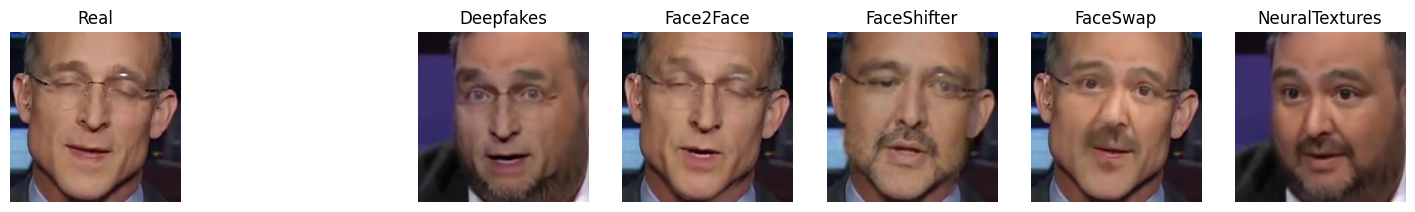

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# SAMPLE VIDEO ID
original_id = '002'
real_video_dir = os.path.join(faces_root, 'real', f'real_original_{original_id}')
real_frame_file = sorted(os.listdir(real_video_dir))[0]
real_img = Image.open(os.path.join(real_video_dir, real_frame_file))

# DEEPFAKE TYPES
fake_types = ['DeepFakeDetection', 'Deepfakes', 'Face2Face', 'FaceShifter', 'FaceSwap', 'NeuralTextures']

plt.figure(figsize=(18,3))
plt.subplot(1, 7, 1)
plt.imshow(real_img)
plt.axis('off')
plt.title('Real')

# PLOTTING FAKE FRAMES ACROSS SAME ORIGINAL VIDEO
for i, fake_type in enumerate(fake_types):
    fake_dir_root = os.path.join(faces_root, 'fake')
    matched_dirs = [d for d in os.listdir(fake_dir_root) if fake_type in d and original_id in d]
    if matched_dirs:
        fake_video_dir = os.path.join(fake_dir_root, matched_dirs[0])
        fake_frame_file = sorted(os.listdir(fake_video_dir))[0]
        fake_img = Image.open(os.path.join(fake_video_dir, fake_frame_file))
        plt.subplot(1, 7, i+2)
        plt.imshow(fake_img)
        plt.axis('off')
        plt.title(fake_type)

plt.show()


In [ ]:
import pandas as pd
metadata = pd.read_csv('/content/drive/MyDrive/DFSCAN/FF++_Metadata.csv')
metadata = metadata[['File Path', 'Label']]
metadata['label_num'] = metadata['Label'].apply(lambda x: 0 if x.upper()=='REAL' else 1)
metadata.head()

,File Path,Label,label_num
0,DeepFakeDetection/01_02__meeting_serious__YVGY...,FAKE,1
1,DeepFakeDetection/01_02__outside_talking_still...,FAKE,1
2,DeepFakeDetection/01_02__talking_against_wall_...,FAKE,1
3,DeepFakeDetection/01_02__walk_down_hall_angry_...,FAKE,1
4,DeepFakeDetection/01_02__walking_down_indoor_h...,FAKE,1


In [ ]:
# MAPPING FACE CROPPED VIDEO FRAMES WITH THEIR RESPECTIVE LABELS
dataset_videos = []

for idx, row in metadata.iterrows():
    file_path_no_ext = row['File Path'].replace('.mp4','').strip()
    video_class, video_id = file_path_no_ext.split('/')
    root_folder = 'real' if row['label_num']==0 else 'fake'
    face_folder_name = f"{root_folder}_{video_class}_{video_id}"
    folder_path = os.path.join(faces_root, root_folder, face_folder_name)
    if os.path.exists(folder_path):
        dataset_videos.append((folder_path, row['label_num']))
    else:
        pass
        # print(f"NOT FOUND: {folder_path}")

print(f"TOTAL VIDEOS MAPPED: {len(dataset_videos)}")

TOTAL VIDEOS MAPPED: 700


In [ ]:
from sklearn.model_selection import train_test_split

# EXTRACTING FOLDER PATH & LABELS
folder_paths = [f for f, l in dataset_videos]
labels = [l for f, l in dataset_videos]

# FIRST SPLIT (TRAIN + (VAL+TEST))
train_folders, temp_folders, train_labels, temp_labels = train_test_split(
    folder_paths, labels,
    test_size=0.3,
    random_state=42,
    stratify=labels
)

# SECOND SPLIT (VAL + TEST)
val_folders, test_folders, val_labels, test_labels = train_test_split(
    temp_folders, temp_labels,
    test_size=0.5,
    random_state=42,
    stratify=temp_labels
)

# COMBINING FOLDER PATH & LABELS
train_videos = list(zip(train_folders, train_labels))
val_videos   = list(zip(val_folders, val_labels))
test_videos  = list(zip(test_folders, test_labels))

print(f"TOTAL TRAINING SAMPLES: {len(train_videos)}")
print(f"TOTAL VALIDATION SAMPLES:   {len(val_videos)}")
print(f"TOTAL TESTING SAMPLES:  {len(test_videos)}")


TOTAL TRAINING SAMPLES: 490
TOTAL VALIDATION SAMPLES:   105
TOTAL TESTING SAMPLES:  105


In [ ]:
from collections import Counter

label_map = {0: 'REAL', 1: 'FAKE'}

def count_labels(video_list):
    labels = [label for _, label in video_list]
    counts = Counter(labels)
    return {label_map[k]: v for k, v in counts.items()}

# Train split
train_counts = count_labels(train_videos)
print("TRAINING LABEL COUNTS:", train_counts)

# Validation split
val_counts = count_labels(val_videos)
print("VALIDATION LABEL COUNTS:", val_counts)

# Test split
test_counts = count_labels(test_videos)
print("TESTING LABEL COUNTS:", test_counts)


TRAINING LABEL COUNTS: {'FAKE': 420, 'REAL': 70}
VALIDATION LABEL COUNTS: {'FAKE': 90, 'REAL': 15}
TESTING LABEL COUNTS: {'FAKE': 90, 'REAL': 15}


**Sidenote:** Highly Imbalanced Dataset. Model Might Be Biased Towards Fake Class. Needs To Handle This Imbalance During Training.

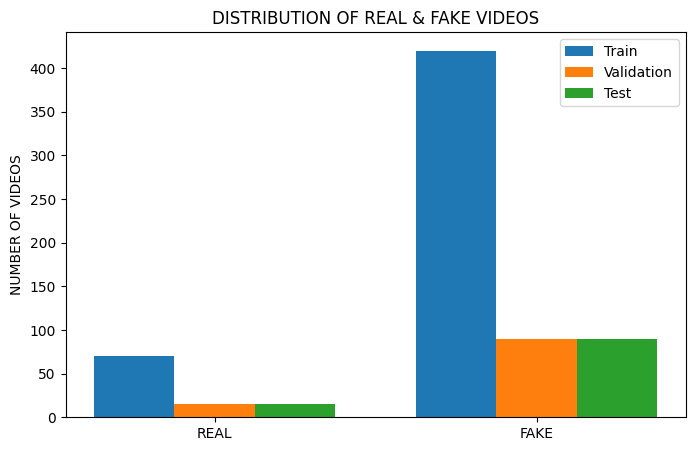

In [ ]:
splits = {
    'Train': train_videos,
    'Validation': val_videos,
    'Test': test_videos
}

label_names = ['REAL', 'FAKE']
counts = {}

for split_name, videos in splits.items():
    labels = [label for _, label in videos]
    counts[split_name] = [labels.count(0), labels.count(1)]

fig, ax = plt.subplots(figsize=(8,5))
bar_width = 0.25
x = range(len(label_names))

for i, (split_name, c) in enumerate(counts.items()):
    ax.bar([p + bar_width*i for p in x], c, width=bar_width, label=split_name)

ax.set_xticks([p + bar_width for p in x])
ax.set_xticklabels(label_names)
ax.set_ylabel('NUMBER OF VIDEOS')
ax.set_title('DISTRIBUTION OF REAL & FAKE VIDEOS')
ax.legend()
plt.show()

In [ ]:
import os
import random
from PIL import Image
import torch
from torch.utils.data import Dataset

class DFSCANData(Dataset):
    def __init__(self, video_list, frames_per_video=10, transform=None, mode='train'):
        """
        video_list: list of tuples -> (folder_path, label)
        frames_per_video: number of frames to sample per video
        transform: torchvision transforms to apply on each frame
        mode: 'train' or 'val/test' (affects frame sampling)
        """
        self.video_list = video_list
        self.frames_per_video = frames_per_video
        self.transform = transform
        self.mode = mode

    def __len__(self):
        return len(self.video_list)

    def __getitem__(self, idx):
        folder_path, label = self.video_list[idx]
        all_frames = sorted([f for f in os.listdir(folder_path) if f.endswith('.jpg') or f.endswith('.png')])

        # --- Sample frames ---
        if len(all_frames) >= self.frames_per_video:
            if self.mode == 'train':
                selected_frames = random.sample(all_frames, self.frames_per_video)
            else:  # val/test -> take first N frames
                selected_frames = all_frames[:self.frames_per_video]
        else:
            # Not enough frames -> use all frames and pad by repeating last frame
            selected_frames = all_frames.copy()
            while len(selected_frames) < self.frames_per_video:
                selected_frames.append(all_frames[-1])

        # --- Load and transform images ---
        images = []
        for f in selected_frames:
            img_path = os.path.join(folder_path, f)
            img = Image.open(img_path).convert('RGB')
            if self.transform:
                img = self.transform(img)
            images.append(img)

        # --- Stack frames: (frames_per_video, C, H, W) ---
        images = torch.stack(images)
        return images, label, folder_path


In [ ]:
# DEFINING TRANSFORMS
import torchvision.transforms as transforms

# Training transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Validation / Test transforms
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [ ]:
# CREATING DATASET INSTANCES
frames_per_video = 10

train_dataset = DFSCANData(train_videos, frames_per_video, transform=train_transform, mode='train')
val_dataset   = DFSCANData(val_videos, frames_per_video, transform=val_transform, mode='val')
test_dataset  = DFSCANData(test_videos, frames_per_video, transform=val_transform, mode='val')


In [ ]:
# WEIGHTED SAMPLER FOR OVERSAMPLING REAL VIDEOS
from torch.utils.data import WeightedRandomSampler

train_labels_list = [label for _, label in train_videos]
counts = Counter(train_labels_list)
weights_per_class = {0: 1.0 / counts[0], 1: 1.0 / counts[1]}
sample_weights = [weights_per_class[label] for label in train_labels_list]

sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

In [ ]:
# CREATING DATALOADERS
from torch.utils.data import DataLoader

batch_size = 16
num_workers = 2

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=num_workers)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

print(f"TRAINING SAMPLES: {len(train_dataset)}, VALIDATION SAMPLES: {len(val_dataset)}, TESTING SAMPLES: {len(test_dataset)}")


TRAINING SAMPLES: 490, VALIDATION SAMPLES: 105, TESTING SAMPLES: 105


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("DEVICE USED:", device)

DEVICE USED: cuda


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

# # GETTING RECOMMENDED WEIGHTS CONFIGURATION
# weights = models.ResNet18_Weights.DEFAULT

# # LOADING MODEL RESNET18
# model = models.resnet18(weights=weights)
# num_features = model.fc.in_features
# model.fc = nn.Linear(num_features, 2)
# model = model.to(device)

class VideoResNet(nn.Module):
    def __init__(self, pretrained=True, num_classes=2):
        super(VideoResNet, self).__init__()
        backbone = models.resnet18(weights=models.ResNet18_Weights.DEFAULT if pretrained else None)
        self.feature_extractor = nn.Sequential(*list(backbone.children())[:-1])
        self.fc = nn.Linear(backbone.fc.in_features, num_classes)

    def forward(self, videos):
        batch_size, num_frames, C, H, W = videos.shape
        videos = videos.view(-1, C, H, W)
        features = self.feature_extractor(videos)
        features = features.view(batch_size, num_frames, -1)
        video_features = features.mean(dim=1)
        logits = self.fc(video_features)
        return logits

model = VideoResNet(pretrained=True).to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 136MB/s]


In [ ]:
# !pip install timm

In [ ]:
# import timm

# class VideoXception(nn.Module):
#     def __init__(self, pretrained=True, num_classes=2):
#         super(VideoXception, self).__init__()
#         # LOADING XCEPTION BACKBONE FROM TIMM
#         backbone = timm.create_model('xception', pretrained=pretrained, num_classes=0)
#         self.feature_extractor = backbone
#         self.fc = nn.Linear(backbone.num_features, num_classes)

#     def forward(self, videos):
#         batch_size, num_frames, C, H, W = videos.shape
#         videos = videos.view(-1, C, H, W)
#         features = self.feature_extractor(videos)
#         features = features.view(batch_size, num_frames, -1)
#         video_features = features.mean(dim=1)
#         logits = self.fc(video_features)
#         return logits

# model = VideoXception(pretrained=True).to(device)

In [ ]:
# DEFINING LOSS & OPTIMIZER
import torch.optim as optim

# CLASS WEIGHTS TO HANDLE IMBALANCE
train_counts = Counter([label for _, label in train_videos])
weight_real = 1.0 / train_counts[0]
weight_fake = 1.0 / train_counts[1]

class_weights = torch.tensor([weight_real, weight_fake], dtype=torch.float).to(device)

# LOSS FUNCTION
criterion = nn.CrossEntropyLoss(weight=class_weights)

# OPTIMIZER
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
# WEIGHTS & BIASES SETUP
!pip install wandb --quiet

In [ ]:
import wandb

# LOGIN
wandb.login()

# PROJECT INITIALIZATION
wandb.init(
    project="DFSCAN-BASELINE",
    name="resnet18_experiment100",
    config={
        "architecture": "ResNet18",
        "frames_per_video": 10,
        "epochs": 100,
        "batch_size": 16,
        "learning_rate": 1e-4,
        "optimizer": "Adam",
        "criterion": "CrossEntropyLoss(weighted)",
        "dataset": "faces_batch1.zip",
    }
)

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: sudipx0 (sudipx0-taylor-s-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


EPOCH 1/100 | TRAIN LOSS: 0.4337 | VAL LOSS: 1.1092 | VAL ACC: 0.4000
MODEL IMPROVEMENT DETECTED. MODEL SAVED.
EPOCH 2/100 | TRAIN LOSS: 0.3024 | VAL LOSS: 1.3641 | VAL ACC: 0.3524
NO IMPROVEMENT FOR 1 EPOCH(S).
EPOCH 3/100 | TRAIN LOSS: 0.2172 | VAL LOSS: 1.0019 | VAL ACC: 0.8286
MODEL IMPROVEMENT DETECTED. MODEL SAVED.
EPOCH 4/100 | TRAIN LOSS: 0.2401 | VAL LOSS: 1.6111 | VAL ACC: 0.3048
NO IMPROVEMENT FOR 1 EPOCH(S).
EPOCH 5/100 | TRAIN LOSS: 0.1668 | VAL LOSS: 0.7400 | VAL ACC: 0.7143
NO IMPROVEMENT FOR 2 EPOCH(S).
EPOCH 6/100 | TRAIN LOSS: 0.1250 | VAL LOSS: 0.9313 | VAL ACC: 0.8476
MODEL IMPROVEMENT DETECTED. MODEL SAVED.
EPOCH 7/100 | TRAIN LOSS: 0.1445 | VAL LOSS: 0.8172 | VAL ACC: 0.7048
NO IMPROVEMENT FOR 1 EPOCH(S).
EPOCH 8/100 | TRAIN LOSS: 0.0965 | VAL LOSS: 0.8455 | VAL ACC: 0.8095
NO IMPROVEMENT FOR 2 EPOCH(S).
EPOCH 9/100 | TRAIN LOSS: 0.0938 | VAL LOSS: 1.1381 | VAL ACC: 0.8571
MODEL IMPROVEMENT DETECTED. MODEL SAVED.
EPOCH 10/100 | TRAIN LOSS: 0.0812 | VAL LOSS: 1.215

EPOCH,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
TRAIN ACC,▁▃▅▅▆▇▇▇▇▇▇▇▇▇███▇█▇███████
TRAIN LOSS,█▆▄▅▃▃▃▂▂▂▂▂▃▂▁▂▁▂▂▂▁▁▁▂▁▁▁
VAL ACC,▂▂▇▁▆▇▆▇▇▇▇▇▅▇▇█▆██▇▇█▇▇███
VAL LOSS,▅▆▄█▂▄▃▃▅▅█▂▃▂▃▄▄▂▄▅▂▃▂▂▁▅▁
BEST VAL ACC,0.92381
EPOCH,27
TRAIN ACC,0.98367
TRAIN LOSS,0.02787
VAL ACC,0.89524
VAL LOSS,0.58245


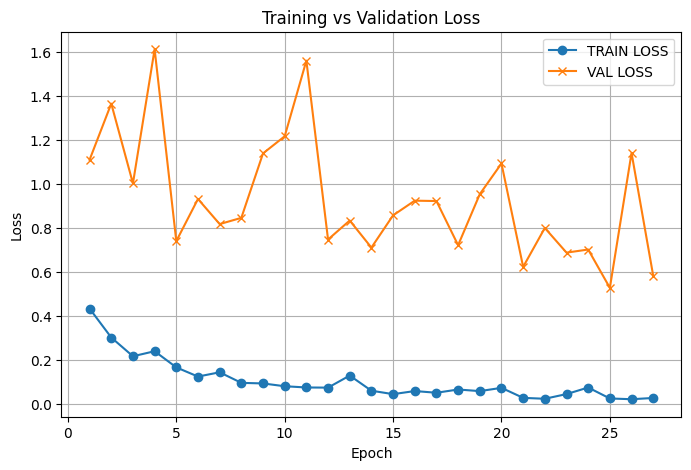

In [ ]:
# TRAINING WITH EARLY STOPPING AND LOSS TRACKING
train_losses, val_losses, val_accs = [], [], []
best_val_acc = 0.0
patience = 5
counter = 0
num_epochs = 100
min_delta = 1e-4

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train, total_train = 0, 0

    for videos, labels, _ in train_loader:
        videos, labels = videos.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(videos)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / len(train_dataset)
    train_acc = correct_train / total_train
    train_losses.append(train_loss)

    # MODEL VALIDATION
    model.eval()
    correct_val, total_val = 0, 0
    val_loss_epoch = 0.0
    with torch.no_grad():
        for videos, labels, _ in val_loader:
            videos, labels = videos.to(device), labels.to(device)
            outputs = model(videos)
            loss = criterion(outputs, labels)
            val_loss_epoch += loss.item() * labels.size(0)

            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_loss_epoch = val_loss_epoch / len(val_dataset)
    val_losses.append(val_loss_epoch)
    val_acc = correct_val / total_val
    val_accs.append(val_acc)

    print(f"EPOCH {epoch+1}/{num_epochs} | "
          f"TRAIN LOSS: {train_loss:.4f} | VAL LOSS: {val_loss_epoch:.4f} | VAL ACC: {val_acc:.4f}")

    # WEIGHTS & BIASES LOGGING
    wandb.log({
    "EPOCH": epoch + 1,
    "TRAIN LOSS": train_loss,
    "VAL LOSS": val_loss_epoch,
    "TRAIN ACC": train_acc,
    "VAL ACC": val_acc
    })

    if val_acc - best_val_acc > min_delta:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "baseline_model.pth")
        wandb.save("baseline_model.pth")
        wandb.run.summary['BEST VAL ACC'] = best_val_acc
        counter = 0
        print("MODEL IMPROVEMENT DETECTED. MODEL SAVED.")
    else:
        counter += 1
        print(f"NO IMPROVEMENT FOR {counter} EPOCH(S).")
        if counter >= patience:
            print(f"EARLY STOPPING TRIGGERED. BEST VAL ACC: {best_val_acc:.4f}")
            break

wandb.finish()
plt.figure(figsize=(8,5))
plt.plot(range(1, len(train_losses)+1), train_losses, label='TRAIN LOSS', marker='o')
plt.plot(range(1, len(val_losses)+1), val_losses, label='VAL LOSS', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import shutil

# SAVING THE MODEL
save_dir = "/content/drive/MyDrive/DFSCAN/models"
os.makedirs(save_dir, exist_ok=True)
final_model_path = os.path.join(save_dir, "baseline_model.pth")

# COPY BEST MODEL
if os.path.exists("baseline_model.pth"):
    shutil.copy("baseline_model.pth", final_model_path)
    print(f"BEST MODEL SUCCESSFULLY COPIED TO GOOGLE DRIVE → {final_model_path}")
else:
    print("NO baseline_model.pth FOUND !")


BEST MODEL SUCCESSFULLY COPIED TO GOOGLE DRIVE → /content/drive/MyDrive/DFSCAN/models/baseline_model.pth


CLASSIFICATION REPORT:

              precision    recall  f1-score   support

        REAL       0.50      0.53      0.52        15
        FAKE       0.92      0.91      0.92        90

    accuracy                           0.86       105
   macro avg       0.71      0.72      0.72       105
weighted avg       0.86      0.86      0.86       105



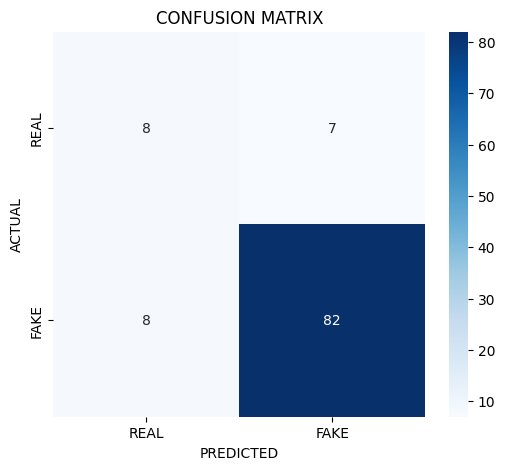

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import torch

# MODEL EVALUATION MODE
model.load_state_dict(torch.load("baseline_model.pth"))
model.eval()

all_video_labels = []
all_video_preds = []
all_video_probs = []

type_correct = defaultdict(int)
type_total = defaultdict(int)

with torch.no_grad():
    for videos, labels, paths in test_loader:
        videos, labels = videos.to(device), labels.to(device)

        # FORWARD PASS
        outputs = model(videos)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_video_labels.extend(labels.cpu().numpy())
        all_video_preds.extend(preds.cpu().numpy())
        all_video_probs.extend(probs.cpu().numpy()[:,1])

        # COMPUTING ACCURACY PER DEEPFAKE TYPE
        for path, pred, label in zip(paths, preds.cpu().numpy(), labels.cpu().numpy()):
            if 'fake_' in path:
                deepfake_type = path.split('fake_')[1].split('_')[0]
            else:
                deepfake_type = 'REAL'
            type_total[deepfake_type] += 1
            if pred == label:
                type_correct[deepfake_type] += 1

# CLASSIFICATION METRICS
report = classification_report(all_video_labels, all_video_preds, target_names=['REAL','FAKE'])
print("CLASSIFICATION REPORT:\n")
print(report)

# CONFUSION MATRIX
cm = confusion_matrix(all_video_labels, all_video_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['REAL','FAKE'], yticklabels=['REAL','FAKE'])
plt.xlabel("PREDICTED")
plt.ylabel("ACTUAL")
plt.title("CONFUSION MATRIX")
plt.show()

In [ ]:
# ROC-AUC score
try:
    roc_auc = roc_auc_score(all_video_labels, all_video_probs)
    print(f"ROC-AUC SCORE: {roc_auc:.4f}")
except:
    print("ROC-AUC COULDN'T BE COMPUTED.")

ROC-AUC SCORE: 0.8415



ACCURACY PER DEEPFAKE TYPE:
Face2Face: 100.00%
NeuralTextures: 83.33%
Deepfakes: 82.35%
FaceSwap: 94.44%
REAL: 53.33%
DeepFakeDetection: 100.00%
FaceShifter: 100.00%


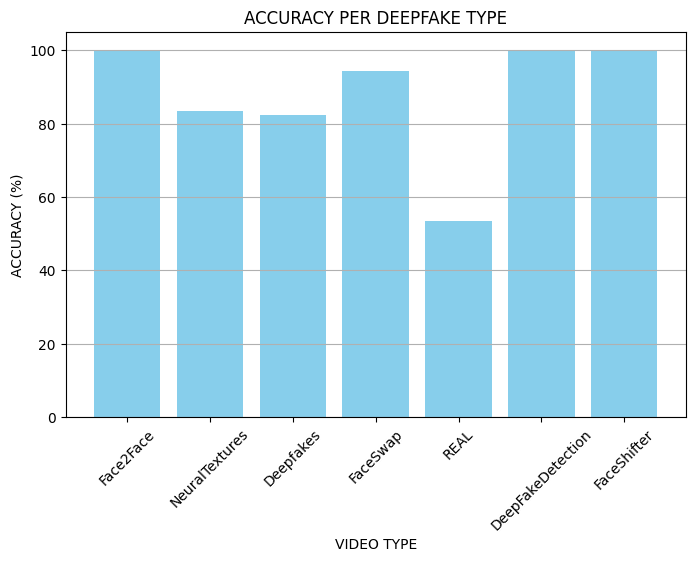

In [ ]:
# PER-DEEPFAKE-TYPE ACCURACY
type_acc = {t: type_correct[t]/type_total[t] for t in type_total}
print("\nACCURACY PER DEEPFAKE TYPE:")
for t, acc in type_acc.items():
    print(f"{t}: {acc*100:.2f}%")

plt.figure(figsize=(8,5))
plt.bar(type_acc.keys(), [acc*100 for acc in type_acc.values()], color='skyblue')
plt.ylabel("ACCURACY (%)")
plt.xlabel("VIDEO TYPE")
plt.title("ACCURACY PER DEEPFAKE TYPE")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

In [ ]:
# MODEL EVALUATION LOGGING TO WEIGHTS & BIASES
wandb.init(project="DFSCAN-Baseline", name="evaluation_metrics", reinit=True)
roc_auc = roc_auc_score(all_video_labels, all_video_probs)
report_dict = classification_report(all_video_labels, all_video_preds, target_names=['REAL','FAKE'], output_dict=True)

wandb.log({
    "TEST ACCURACY": report_dict['accuracy'],
    "ROC AUC": roc_auc,
    "REAL PRECISION": report_dict['REAL']['precision'],
    "REAL RECALL": report_dict['REAL']['recall'],
    "FAKE PRECISION": report_dict['FAKE']['precision'],
    "FAKE RECALL": report_dict['FAKE']['recall']
})

wandb.log({"CONFUSION MATRIX": wandb.Image(cm)})

plt.figure(figsize=(8,5))
plt.bar(type_acc.keys(), [acc*100 for acc in type_acc.values()], color='skyblue')
plt.ylabel("ACCURACY (%)")
plt.xlabel("VIDEO TYPE")
plt.title("ACCURACY PER DEEPFAKE TYPE")
wandb.log({"PER-TYPE ACCURACY": wandb.Image(plt)})
plt.close()

wandb.finish()

wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


FAKE PRECISION,▁
FAKE RECALL,▁
REAL PRECISION,▁
REAL RECALL,▁
ROC AUC,▁
TEST ACCURACY,▁
FAKE PRECISION,0.92135
FAKE RECALL,0.91111
REAL PRECISION,0.5
REAL RECALL,0.53333
ROC AUC,0.84148
